In [177]:
import torch 
from torch import nn, Tensor
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torchvision import transforms
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from PIL import Image
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [178]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),   # 确保尺寸一致
    transforms.ToTensor(),           # 转为 [C, H, W]，并除以255
])
img = Image.open("dataset/converted_100x100.png").convert("RGB")
img_tensor = transform(img).unsqueeze(0)
img_tensor = img_tensor * 2 - 1                # normalize to [-1, 1]
img_tensor = img_tensor.view(1, -1)  


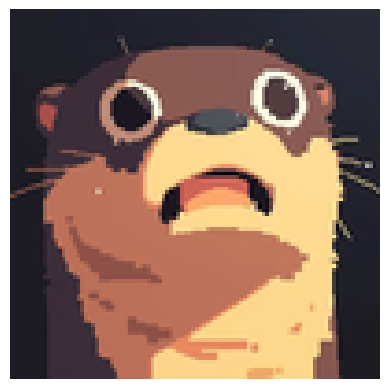

In [179]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [173]:
img_tensor.shape

torch.Size([1, 30000])

In [44]:
dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
image,label = dataset[1000]

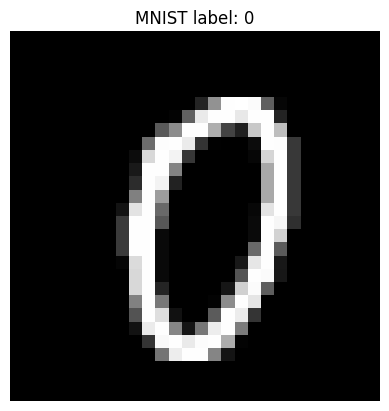

In [45]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"MNIST label: {label}")
plt.axis("off")
plt.show()

In [46]:
image = image * 2 - 1                # normalize to [-1, 1]
image = image.view(1, -1)             # flatten to (1, 784)

In [180]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        #print(t.shape, x_t.shape)
        res = self.net(torch.cat((t, x_t), -1))
        #print(res)
        return res
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        # mid-point ODE solver here for simplicity
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

In [162]:
class Flow(nn.Module):
    def __init__(self, dim: int = 3, h: int = 64):
        super().__init__()
        out_channels = dim * 2  # scale + shift

        self.net = nn.Sequential(
            nn.Conv2d(dim + 1, h, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(h, h, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(h, dim, kernel_size=3, padding=1),
        )
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        #print(t.shape, x_t.shape)
        t_img = t.view(x_t.size(0),1,1,1).expand(-1,1,x_t.size(2),x_t.size(3))
        res = self.net(torch.cat([x_t, t_img], dim=1))
        #print(res)
        return res
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        # mid-point ODE solver here for simplicity
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

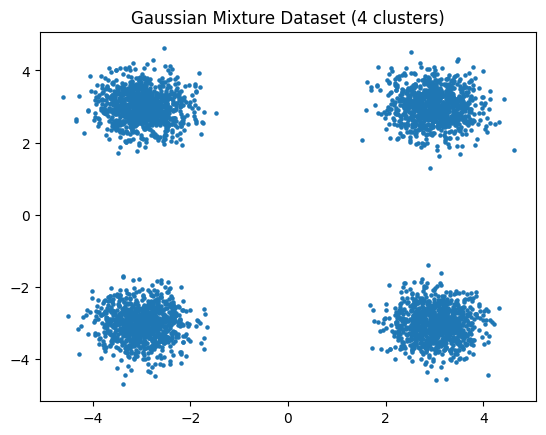

In [5]:
import torch
import matplotlib.pyplot as plt

num_samples = 1000

means = [[-3, -3], [3, -3], [-3, 3], [3, 3]]  # 四个高斯中心
cov = [[0.2, 0], [0, 0.2]]                   # 每个高斯使用相同协方差
num_samples_per_cluster = 1000

data = []

for mean in means:
    gaussian = np.random.multivariate_normal(mean, cov, num_samples_per_cluster)
    data.append(gaussian)

data = np.vstack(data)

plt.scatter(data[:, 0], data[:, 1], s=5)
plt.title("Gaussian Mixture Dataset (4 clusters)")
plt.show()

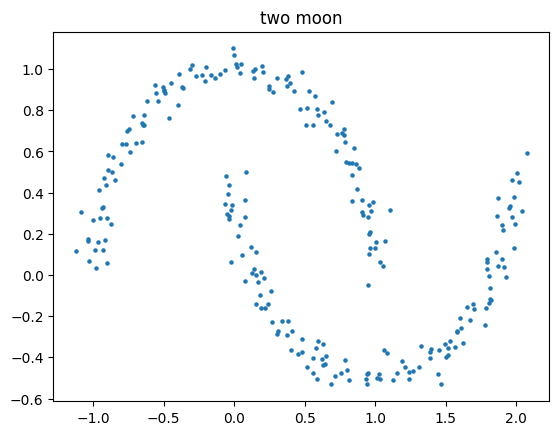

In [38]:
data = make_moons(256, noise=0.05)[0]
plt.scatter(data[:, 0], data[:, 1], s=5)
plt.title("two moon")
plt.show()

# Training

In [ ]:
flow = Flow(dim=30000,h=128).to(device=DEVICE)

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in tqdm(range(5000)):
    #x_1 = Tensor(make_moons(256, noise=0.05)[0])
    #x_1 = Tensor(make_circles(1024, factor=0.2, noise=0.05)[0])
    #x_1 = Tensor(make_moons((256,50), noise=0.05)[0])
    #x_1 = Tensor(data)
    #x_1 = image
    x_1 = img_tensor.to(device=DEVICE)
    x_0 = torch.randn_like(x_1).to(device=DEVICE)
    t = torch.rand(len(x_1), 1).to(device=DEVICE)
    
    x_t = (1 - t) * x_0 + t * x_1 # linear interpolation
    dx_t = x_1 - x_0 # target flow
    #break
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()
    

100%|██████████| 5000/5000 [00:08<00:00, 578.84it/s]


In [110]:
x_t.shape

torch.Size([1, 784])

In [111]:
x_1.shape

torch.Size([1, 784])

# Sampling

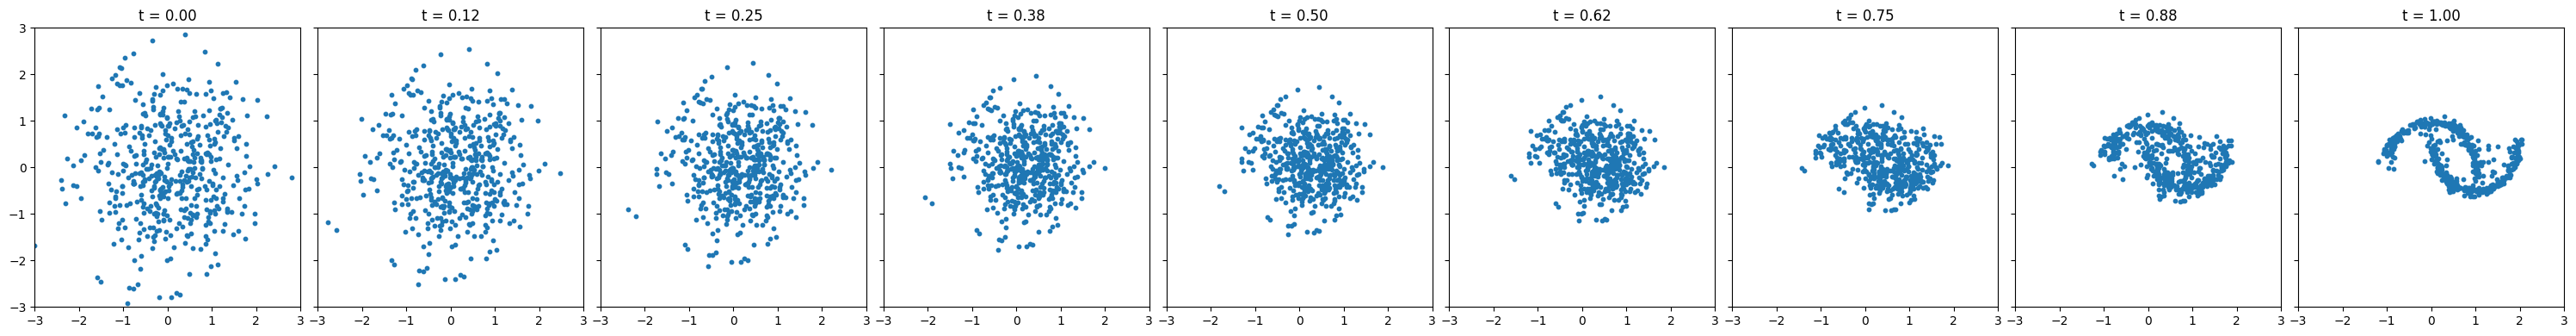

In [59]:
#x = torch.randn(4000, 2)
x = torch.randn(500, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1]) # solve ODE
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 336.12it/s]


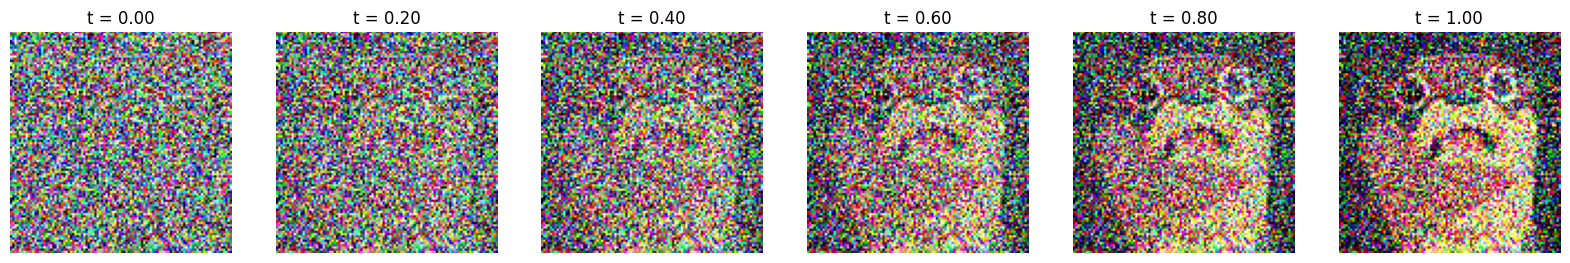

In [185]:
x = torch.randn_like(x_1).cpu()     # start from noise
n_steps = 500
time_steps = torch.linspace(0, 1.0, n_steps + 1)

fig, axes = plt.subplots(1, n_steps // 100 + 1, figsize=(20, 3))
flow.cpu()
for i in tqdm(range(n_steps)):
    if i % 100 == 0:
        a = i // 100
        img = x.view(3, 100, 100).permute(1, 2, 0).detach()
        img_norm = (img + 1) / 2   # 假设 x ∈ [-1,1]
        img_norm = torch.clamp(img_norm, 0, 1)
        axes[a].imshow(img_norm)
        axes[a].set_title(f"t = {time_steps[i]:.2f}")
        axes[a].axis("off")

    x = flow.step(x, time_steps[i], time_steps[i + 1])

img = x.view(3, 100, 100).permute(1, 2, 0).detach()
img_norm = (img + 1) / 2   # 假设 x ∈ [-1,1]
img_norm = torch.clamp(img_norm, 0, 1)
axes[-1].imshow(img_norm)
axes[-1].set_title(f"t = {time_steps[-1]:.2f}")
axes[-1].axis("off")

plt.show()

# Conditional Flow Matching
We now train a simple conditional model using class labels.

In [ ]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [ ]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 2, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, c: Tensor, x_t: Tensor ) -> Tensor:
        return self.net(torch.cat((t, c, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor, c: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, c = c, x_t= x_t + self(c = c, x_t=x_t, t=t_start) * (t_end - t_start) / 2)

# Training

In [ ]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1, c = make_moons(256, noise=0.15)
    x_1 = Tensor(x_1)
    c = Tensor(c)
    c = c.view(-1, 1)
    
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t, c=c), dx_t).backward()
    optimizer.step()

# Sampling

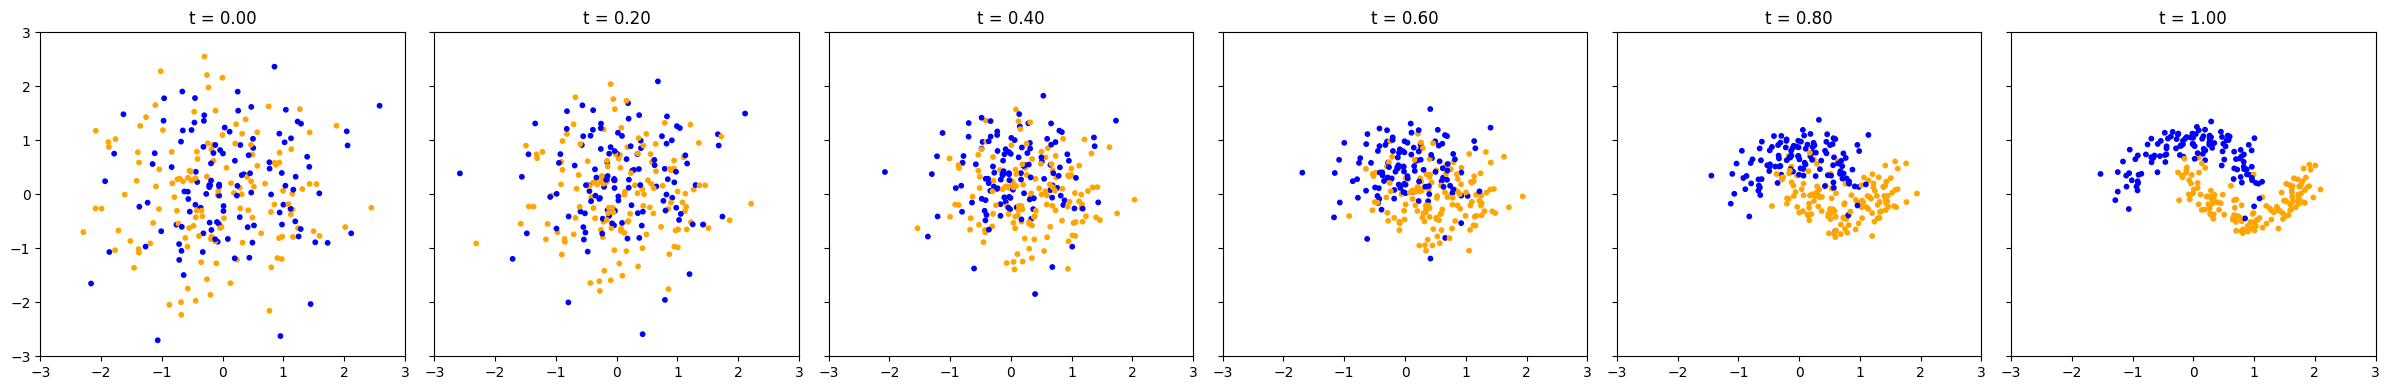

In [ ]:
# --- evaluation / visualisation section --------------------------
n_samples = 256                    

sigma = 1.0
x      = torch.randn(n_samples, 2) * sigma     # (n_samples, 2)

# if you just want random labels –– otherwise load real labels here
c_eval = torch.randint(0, 2, (n_samples, 1), dtype=torch.float32)  # (n_samples, 1)

# colours for the scatter (same length as x)
colors  = ['blue' if lbl == 0 else 'orange' for lbl in c_eval.squeeze().tolist()]

# -----------------------------------------------------------------
n_steps      = 100
plot_every   = 20
plot_indices = list(range(0, n_steps + 1, plot_every))
if plot_indices[-1] != n_steps:
    plot_indices.append(n_steps)

fig, axes   = plt.subplots(1, len(plot_indices), figsize=(4 * len(plot_indices), 4),
                           sharex=True, sharey=True)
time_steps  = torch.linspace(0, 1.0, n_steps + 1)

# initial frame
axes[0].scatter(x[:, 0], x[:, 1], s=10, c=colors)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

plot_count = 0
with torch.no_grad():                         # no gradients while sampling
    for i in range(n_steps):
        x = flow.step(x_t=x,
                      t_start=time_steps[i],
                      t_end=time_steps[i + 1],
                      c=c_eval)               # 2️⃣ use the same‑sized label tensor
        if (i + 1) in plot_indices:
            plot_count += 1
            axes[plot_count].scatter(x[:, 0], x[:, 1], s=10, c=colors)
            axes[plot_count].set_title(f't = {time_steps[i + 1]:.2f}')
            axes[plot_count].set_xlim(-3.0, 3.0)
            axes[plot_count].set_ylim(-3.0, 3.0)

plt.tight_layout()
plt.show()
